# AMS 526 Hw2
# Estimate the matrix condition number in 1-norm




#### Matrix condition number is defined as $\kappa(A)$=$\| A \|_1 \| A^{-1} \|_1$. In practice, compute 1-norm of A is easy, but find the inverse 
#### of A is time-consuming. We could let $Az=y$ and use the ratio $\|z\|_1/\|y\|_1$ as an estimation of $\|A^{-1}\|_1$, with some heuristic 
#### choice of vector y.

In [142]:
import numpy as np
import scipy.linalg as lin
from typing import Tuple
import matplotlib.pyplot as plt

#### The core of the estimation method is finding the right y. It is computed from $A^Ty=c$, where c's components are either 1 or -1. First we conduct LU decomposition of A, getting $PA=LU$, $L^TPy=v$ and $U^Tv=c$. At each forward substitution of solving lower triangular $U^Tv=c$, we want to maximum the corresponding $|v_i|$. 
#### Explicitly, $v_i = (c_i - \sum_{j=1}^{i-1} U^T_{ij}v_j) / U^T_{ii}$. To make $v_i$ larger in magnitude, we set the sign of c_i is opposite to the following sum using np sign function.

In [143]:
# Find c which makes the largest v
def c_sel(U_T:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

    assert np.allclose(U_T, np.tril(U_T)), ['A is not lower triangular']
    n = U_T.shape[0]
    x = np.zeros(n)
    c = np.ones(n)

    for i in range(n):
        sum_ = 0
        for j in range(i):
            sum_ += U_T[i, j] * x[j]
        # Make sure c_i has opposite sign of the sum
        c[i] = c[i] * - np.where(np.sign(sum_) >= 0, 1, -1)
        x[i] = (c[i] - sum_) / U_T[i, i]
    return c, x


In [144]:
# Test the c_sel function with random non-singular matrix 
def generate_invertible_matrix(n):
    while True:
        matrix = np.random.rand(n, n)
        if np.linalg.det(matrix) != 0:
            return matrix
P0, L, U = lin.lu(generate_invertible_matrix(6))
c , v = c_sel(U.T)
print(c)

[-1.  1. -1.  1.  1. -1.]


#### Then we can compute vector y by built-in function solve_triangular. Also we can solve $Az=y$ using LU decomposition. Finally we can compute the estimated condition number.

In [145]:
# Estimate the condition number using the strange method
def condition(A:np.ndarray) -> float:
    assert np.linalg.det(A) != 0, ['A is singular']
    # LU decomposition of A. Notice P is defined differently from the textbook, so needs transpose
    P0, L, U = lin.lu(A) # A = PLU
    P = P0.T
    # Solve U^Tv=c to pick v with largest 1-norm
    c, v = c_sel(U.T)
    # Solve L^Ty=v
    Py = lin.solve_triangular(L.T, v)
    y = np.dot(P.T, Py)

    # Solve Az=y by LU decomposition
    Uz = lin.solve_triangular(L, np.dot(P,y), lower=True)
    z = lin.solve_triangular(U, Uz)

    cn_inverse = lin.norm(z, ord=1) / lin.norm(y, ord=1)

    cn = cn_inverse * lin.norm(A, ord=1)

    return cn

#### To check our algorithm, we directly compute the inverse of A and compute the condition number. It is also down by LU decomposition, which has been stated in question 5.

In [146]:
# Compute the condition number explicitly by computing inverse
def explicit_cn(A:np.ndarray) -> float:
    assert np.linalg.det(A) != 0, ['A is singular']
    P0, L, U = lin.lu(A) # A = PLU
    P = P0.T   
    n = A.shape[0]
    inverse_A = np.zeros((n,n))

    for j in range(n):
    # LUA^-1=PI, solve Lx_i=P_i, then Uy_i=x_i
        e_i = P[:, j]
        x_i = lin.solve_triangular(L, e_i, lower=True)
        y_i = lin.solve_triangular(U, x_i)
        inverse_A[:, j] = y_i

    cn = lin.norm(A, ord=1) * lin.norm(inverse_A, ord=1)
    return cn

In [147]:
def hilbert_matrix(n):
    return np.array([[1 / (i + j + 1) for j in range(n)] for i in range(n)])

#### We use error relative the explicit method to test our algorithm. The accurancy is between 0.1 and 0.3 for Hilbert matrix of different order.

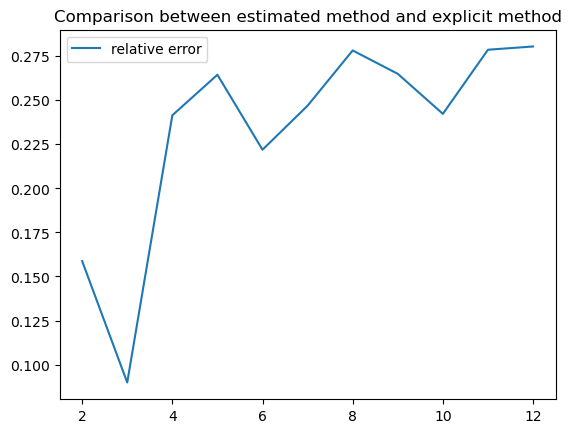

In [148]:
orders = [i for i in range(2,13)]
cn_list = [0] * len(orders)
ex_cn_list = [0] * len(orders)
for i, n in enumerate(orders):
    H = hilbert_matrix(n)
    cn_list[i] = condition(H)
    ex_cn_list[i] = explicit_cn(H)

rel_error = abs(np.array(cn_list) - np.array(ex_cn_list)) / np.array(ex_cn_list)
plt.plot(orders, rel_error, label='relative error')
# plt.plot(orders, cn_list, label='relative error')
# plt.plot(orders, ex_cn_list, label='explicit')
plt.title('Comparison between estimated method and explicit method')
# plt.yscale('log')
plt.legend()
plt.show()
    

#### But the estimation method is generally faster than explicit method. In terms of flops, estimation method only have one step that is $O(n^3)$ flops, which is the LU decomposition taking $\frac{2}{3}n^3$, and all the other steps are solving triangular system, which are $O(n^2)$. For the explicit method, according to question 5 it has $2n^3$ flops.
#### The measured runtime also confirm this: for large n the runtime of explicit method grow faster than estimation method.

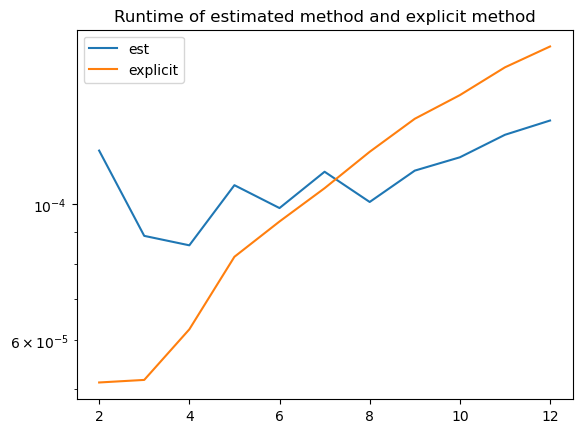

In [151]:
import timeit

it_number = 100
cn_t_list = [0] * len(orders)
ecn_t_list = [0] * len(orders)
for i, n in enumerate(orders):
    H = hilbert_matrix(n)
    cn_t_list[i] = timeit.timeit("condition(H)", globals=globals(), number=it_number) / it_number
    ecn_t_list[i] = timeit.timeit("explicit_cn(H)", globals=globals(), number=it_number) / it_number
    
plt.plot(orders, cn_t_list, label='est')
plt.plot(orders, ecn_t_list, label='explicit')
plt.title('Runtime of estimated method and explicit method')
plt.yscale('log')
plt.legend()
plt.show()

In [3]:
## For question 4
# import numpy as np

# def generate_upper_triangular(n):
#     # Create an n x n identity matrix
#     matrix = np.eye(n)
    
#     # Set the upper triangular part (excluding the diagonal) to -1
#     for i in range(n):
#         for j in range(i + 1, n):
#             matrix[i, j] = -1
    
#     return matrix

# # Test with n=5
# n = 5
# upper_triangular_matrix = generate_upper_triangular(n)
# upper_triangular_matrix

# A = np.linalg.inv(upper_triangular_matrix)
# A

# cn = np.linalg.norm(A, ord='fro')
# print(cn)

10.816653826391969
